# Message passing neural network for segment classification on ACTS data

In this notebook we'll implement a model similar to the Interaction Networks model:
https://arxiv.org/abs/1612.00222

The model will consider a graph of connected hits and try to determine which edges are real and which are spurious.

In [1]:
# Training concurrency
import os
os.environ['OMP_NUM_THREADS'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

cuda = False

In [2]:
%load_ext autoreload
%autoreload 2

# System imports
from __future__ import print_function
import os
import multiprocessing as mp
from timeit import default_timer as timer

# Externals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.model_selection import train_test_split

# Torch imports
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

# Local imports
from estimator import Estimator
from acts import process_hits_files, select_barrel_hits

%matplotlib notebook

In [3]:
if cuda:
    np_to_torch = lambda x, volatile=False: (
        Variable(torch.from_numpy(x.astype(np.float32)), volatile=volatile).cuda())
else:
    np_to_torch = lambda x, volatile=False: (
        Variable(torch.from_numpy(x.astype(np.float32)), volatile=volatile))

torch_to_np = lambda x: x.cpu().data.numpy()

## Data utilities

In [4]:
def select_hits(hits):
    # Select all barrel hits
    vids = [8, 13, 17]
    hits = hits[np.logical_or.reduce([hits.volid == v for v in vids])]
    # Re-enumerate the volume and layer numbers for convenience
    volume = pd.Series(-1, index=hits.index, dtype=np.int8)
    vid_groups = hits.groupby('volid')
    for i, v in enumerate(vids):
        volume[vid_groups.get_group(v).index] = i
    # This assumes 4 layers per volume (except last volume)
    layer = (hits.layid / 2 - 1 + volume * 4).astype(np.int8)
    # Select the columns we need
    hits = (hits[['evtid', 'barcode', 'r', 'phi', 'z']]
            .assign(volume=volume, layer=layer))
    # Filter tracks that hit every layer
    hits = (hits.groupby(['evtid', 'barcode'])
            .filter(lambda x: len(x.layer.unique()) == 10))
    # Remove duplicate hits
    hits = hits.loc[
        hits.groupby(['evtid', 'barcode', 'layer'], as_index=False).r.idxmin()
    ]
    return hits

## Prepare the data

In [5]:
input_dir = '/data/ntran/prod_mu10_pt1000_2017_07_29'

In [6]:
all_files = os.listdir(input_dir)
hits_files = sorted(f for f in all_files if f.startswith('clusters'))

n_files = 7
hits_files = [os.path.join(input_dir, hf) for hf in hits_files[:n_files]]

In [7]:
%%time

n_workers = 10
with mp.Pool(processes=n_workers) as pool:
    hits = process_hits_files(hits_files, pool)
    print('Applying selections')
    hits = pool.map(select_hits, hits)

# Concatenate everything together
hits = pd.concat(hits, ignore_index=True)

Loading /data/ntran/prod_mu10_pt1000_2017_07_29/clusters_10.csv
Loading /data/ntran/prod_mu10_pt1000_2017_07_29/clusters_1.csv
Loading /data/ntran/prod_mu10_pt1000_2017_07_29/clusters_11.csv
Loading /data/ntran/prod_mu10_pt1000_2017_07_29/clusters_12.csv
Loading /data/ntran/prod_mu10_pt1000_2017_07_29/clusters_13.csv
Loading /data/ntran/prod_mu10_pt1000_2017_07_29/clusters_14.csv
Loading /data/ntran/prod_mu10_pt1000_2017_07_29/clusters_15.csv
Applying selections
CPU times: user 564 ms, sys: 353 ms, total: 917 ms
Wall time: 1min 26s


### Construct the dataset

In [8]:
# Select the particle keys
particle_keys = hits[['evtid', 'barcode']].drop_duplicates().values
np.random.shuffle(particle_keys)
particle_keys.shape

(95209, 2)

In [9]:
# Data config
n_tracks = 15
n_samples = particle_keys.shape[0] // n_tracks
feature_names = ['r', 'phi', 'z']
n_features = len(feature_names)
feature_scale = np.array([1000., np.pi, 1000.])
print('Preparing', n_samples, 'samples with', n_tracks, 'tracks each')
assert n_samples <= (particle_keys.shape[0] // n_tracks), 'Not enough tracks!'

Preparing 6347 samples with 15 tracks each


In [10]:
# Fixed number of hits and edges per sample in this dataset
n_det_layers = hits.layer.unique().shape[0]
n_hits = n_tracks * n_det_layers
n_edges = n_tracks**2 * (n_det_layers - 1)
edge_idx = np.arange(n_edges)
n_hits, n_edges

(150, 2025)

In [11]:
# Pre-allocate the dataset storage
full_X = np.zeros((n_samples, n_hits, n_features))
full_Ri = np.zeros((n_samples, n_hits, n_edges), dtype=np.uint8)
full_Ro = np.zeros((n_samples, n_hits, n_edges), dtype=np.uint8)
full_y = np.zeros((n_samples, n_edges), dtype=np.uint8)

In [12]:
%%time

sig_groups = hits.groupby(['evtid', 'barcode'])

# Loop over samples
for i in range(n_samples):
    # Pick out the particles for this sample
    sample_keys = particle_keys[i*n_tracks:(i+1)*n_tracks]
    sample_hits = pd.concat([sig_groups.get_group(tuple(k)) for k in sample_keys])

    # Select adjacent-layer hit pairs.
    sample_layers = sample_hits.layer.values
    adj_idx = np.stack(np.where((sample_layers[None,:] - sample_layers[:,None]) == 1), axis=1)
    
    # Fill the adjacency matrices
    full_Ri[i, adj_idx[:,1], edge_idx] = 1
    full_Ro[i, adj_idx[:,0], edge_idx] = 1
    
    # Fill the node features
    full_X[i] = sample_hits[feature_names].values / feature_scale
    
    # Fill the edge labels
    barcodes = sample_hits.barcode.values
    bc_in = np.matmul(barcodes[None], full_Ri[i]).squeeze(0)
    bc_out = np.matmul(barcodes[None], full_Ro[i]).squeeze(0)
    full_y[i] = (bc_in == bc_out)

CPU times: user 35.6 s, sys: 295 ms, total: 35.9 s
Wall time: 35.8 s


### Visualize one sample

Need to put this code into a function, and write it so it will be easy to use
at model evaluation time (e.g., using model representation of the data).

In [13]:
def draw_sample(X, Ri, Ro, y, cmap='bwr_r', alpha_labels=False):
    """
    TODO: make segment coloring configurable.
    """
    # Select the i/o node features for each segment
    feats_o = X[np.where(Ri.T)[1]]
    feats_i = X[np.where(Ro.T)[1]]
    # Prepare the figure
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9,4))
    cmap = plt.get_cmap(cmap)
    
    # Draw the hits (r, phi, z)
    ax0.scatter(X[:,2], X[:,0], c='k')
    ax1.scatter(X[:,1], X[:,0], c='k')
    
    # Draw the segments
    for j in range(y.shape[0]):
        if alpha_labels:
            seg_args = dict(c='k', alpha=float(y[j]))
        else:
            seg_args = dict(c=cmap(float(y[j])))
        ax0.plot([feats_o[j,2], feats_i[j,2]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
        ax1.plot([feats_o[j,1], feats_i[j,1]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
    # Adjust axes
    #ax0.set_xlim(-1100, 1100)
    ax1.set_xlim(-np.pi, np.pi)
    ax0.set_xlabel('$z$ [mm]')
    ax1.set_xlabel('$\phi$ [rad]')
    ax0.set_ylabel('$r$ [mm]')
    ax1.set_ylabel('$r$ [mm]')
    plt.tight_layout()

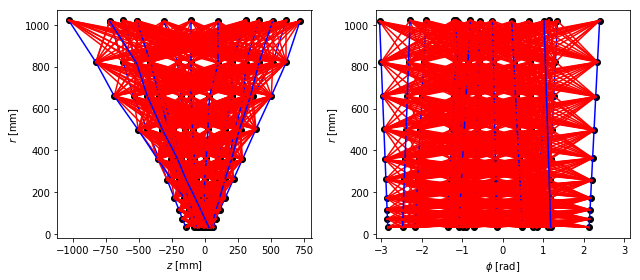

In [14]:
# Choose a sample to draw
i = 0
X = full_X[i] * feature_scale
Ri, Ro = full_Ri[i], full_Ro[i]
y = full_y[i]

draw_sample(X, Ri, Ro, y)

## Define the model

In [15]:
class EdgeNetwork(nn.Module):
    """
    A module which computes weights for edges of the graph.
    For each edge, it selects the associated nodes' features
    and applies some fully-connected network layers with a final
    sigmoid activation.
    """
    def __init__(self, input_dim, hidden_dim=8, hidden_activation=nn.Tanh):
        super(EdgeNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim*2, hidden_dim),
            hidden_activation(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid())
    def forward(self, X, Ri, Ro):
        # Select the features of the associated nodes
        bo = torch.matmul(Ro.transpose(1, 2), X)
        bi = torch.matmul(Ri.transpose(1, 2), X)
        B = torch.cat([bo, bi], dim=2)
        # Apply the network to each edge
        return self.network(B).squeeze(-1)

class NodeNetwork(nn.Module):
    """
    A module which computes new node features on the graph.
    For each node, it aggregates the neighbor node features
    (separately on the input and output side), and combines
    them with the node's previous features in a fully-connected
    network to compute the new features.
    """
    def __init__(self, input_dim, output_dim, hidden_activation=nn.Tanh):
        super(NodeNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim*3, output_dim),
            hidden_activation(),
            nn.Linear(output_dim, output_dim),
            hidden_activation())
    def forward(self, X, e, Ri, Ro):
        bo = torch.matmul(Ro.transpose(1, 2), X)
        bi = torch.matmul(Ri.transpose(1, 2), X)
        Rwo = Ro * e[:,None]
        Rwi = Ri * e[:,None]
        mi = torch.matmul(Rwi, bo)
        mo = torch.matmul(Rwo, bi)
        M = torch.cat([mi, mo, X], dim=2)
        return self.network(M)

class SegmentClassifier(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=8, n_iters=3, hidden_activation=nn.Tanh):
        super(SegmentClassifier, self).__init__()
        self.n_iters = n_iters
        # Setup the input network
        self.input_network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            hidden_activation())
        # Setup the edge network
        self.edge_network = EdgeNetwork(input_dim+hidden_dim, hidden_dim, hidden_activation)
        # Setup the node layers
        self.node_network = NodeNetwork(input_dim+hidden_dim, hidden_dim, hidden_activation)

    def forward(self, inputs):
        """Apply forward pass of the model"""
        X, Ri, Ro = inputs
        # Apply input network to get hidden representation
        H = self.input_network(X)
        # Shortcut connect the inputs onto the hidden representation
        H = torch.cat([H, X], dim=-1)
        # Loop over iterations of edge and node networks
        for i in range(self.n_iters):
            # Apply edge network
            e = self.edge_network(H, Ri, Ro)
            # Apply node network
            H = self.node_network(H, e, Ri, Ro)
            # Shortcut connect the inputs onto the hidden representation
            H = torch.cat([H, X], dim=-1)
        # Apply final edge network
        return self.edge_network(H, Ri, Ro)

## Train the model

In [16]:
# Develop a batch generator here
def batch_generator(X, Ri, Ro, y, n_samples=1, batch_size=1, train=True):
    volatile = not train
    batch_idxs = np.arange(0, n_samples, batch_size)
    # Loop over epochs
    while True:
        # Loop over batches
        for j in batch_idxs:
            batch_X = np_to_torch(X[j:j+batch_size], volatile=volatile)
            batch_Ri = np_to_torch(Ri[j:j+batch_size], volatile=volatile)
            batch_Ro = np_to_torch(Ro[j:j+batch_size], volatile=volatile)
            batch_y = np_to_torch(y[j:j+batch_size], volatile=volatile)
            batch_inputs = [batch_X, batch_Ri, batch_Ro]
            yield batch_inputs, batch_y

In [17]:
# Model config
hidden_dim = 32
n_iters = 4

# Training config
batch_size = 32
n_epochs = 13
valid_frac = 0.2
test_frac = 0.2

In [18]:
# We round by batch_size to avoid partial batches
n_test = int(n_samples * test_frac) // batch_size * batch_size
n_valid = int(n_samples * valid_frac) // batch_size * batch_size
n_train = (n_samples - n_valid - n_test) // batch_size * batch_size
n_train_batches = n_train // batch_size
n_valid_batches = n_valid // batch_size
n_test_batches = n_test // batch_size

n_train, n_valid, n_test, n_train + n_valid + n_test

(3840, 1248, 1248, 6336)

In [19]:
# Partition the dataset
(train_X, test_X, train_Ri, test_Ri, train_Ro, test_Ro, train_y, test_y) = (
    train_test_split(full_X, full_Ri, full_Ro, full_y, test_size=n_test))
(train_X, valid_X, train_Ri, valid_Ri, train_Ro, valid_Ro, train_y, valid_y) = (
    train_test_split(train_X, train_Ri, train_Ro, train_y, test_size=n_valid))

In [20]:
print('Train shapes:', train_X.shape, train_Ri.shape, train_Ro.shape, train_y.shape)
print('Valid shapes:', valid_X.shape, valid_Ri.shape, valid_Ro.shape, valid_y.shape)
print('Test shapes: ', test_X.shape, test_Ri.shape, test_Ro.shape, test_y.shape)

Train shapes: (3851, 150, 3) (3851, 150, 2025) (3851, 150, 2025) (3851, 2025)
Valid shapes: (1248, 150, 3) (1248, 150, 2025) (1248, 150, 2025) (1248, 2025)
Test shapes:  (1248, 150, 3) (1248, 150, 2025) (1248, 150, 2025) (1248, 2025)


In [21]:
# Prepare the batch generators
train_batcher = batch_generator(train_X, train_Ri, train_Ro, train_y,
                                n_samples=n_train, batch_size=batch_size)
valid_batcher = batch_generator(valid_X, valid_Ri, valid_Ro, valid_y, train=False,
                                n_samples=n_valid, batch_size=batch_size)
test_batcher = batch_generator(test_X, test_Ri, test_Ro, test_y, train=False,
                               n_samples=n_test, batch_size=batch_size)

In [22]:
# Construct the model
model = SegmentClassifier(input_dim=n_features, hidden_dim=hidden_dim, n_iters=n_iters)
loss_func = nn.BCELoss()
estim = Estimator(model, loss_func=loss_func, cuda=cuda)

2018-07-09 16:42:54.298224 Model: 
SegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=70, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
      (3): Sigmoid()
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=105, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): Tanh()
    )
  )
)
2018-07-09 16:42:54.298517 Parameters: 6881


In [29]:
estim.load_checkpoint('Prune/000001.pt')

In [30]:
estim.fit_gen(train_batcher, n_batches=n_train_batches, n_epochs=n_epochs,
              valid_generator=valid_batcher, n_valid_batches=n_valid_batches, 
              filename='Prune/000001.pt')

2018-07-09 16:57:27.883431 Epoch 13
2018-07-09 17:01:14.112101   training loss 0.123 time 226.228s


/home/sjenkins/miniconda3/envs/pytorch-training/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


2018-07-09 17:01:49.888103   validate loss 0.113
2018-07-09 17:01:49.888470  save checkpoint
2018-07-09 17:01:49.890718 Epoch 14
2018-07-09 17:05:04.904224   training loss 0.104 time 195.013s
2018-07-09 17:05:40.648869   validate loss 0.0949
2018-07-09 17:05:40.648959  save checkpoint
2018-07-09 17:05:40.651668 Epoch 15
2018-07-09 17:08:59.622290   training loss 0.0881 time 198.97s
2018-07-09 17:09:41.065971   validate loss 0.0802
2018-07-09 17:09:41.066051  save checkpoint
2018-07-09 17:09:41.068484 Epoch 16
2018-07-09 17:12:36.545659   training loss 0.0745 time 175.477s
2018-07-09 17:13:09.997017   validate loss 0.0687
2018-07-09 17:13:09.997100  save checkpoint
2018-07-09 17:13:09.999421 Epoch 17
2018-07-09 17:16:04.134835   training loss 0.0643 time 174.135s
2018-07-09 17:16:37.600406   validate loss 0.0592
2018-07-09 17:16:37.600484  save checkpoint
2018-07-09 17:16:37.602887 Epoch 18


KeyboardInterrupt: 

In [ ]:
estim.load_checkpoint('Prune/0.pt')

### Loss curves

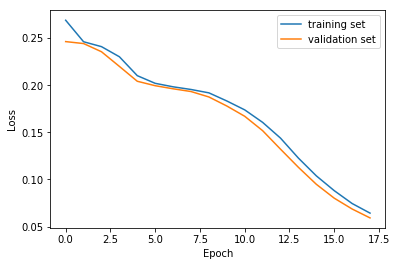

In [31]:
# Plot the loss
plt.figure()
plt.plot(estim.train_losses, label='training set')
plt.plot(estim.valid_losses, label='validation set')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=0);

## Evaluate model on the test set

In [ ]:
test_pred = torch_to_np(estim.predict(test_batcher, n_test_batches))

In [ ]:
flat_y = test_y.flatten()
flat_pred = test_pred.flatten()
thresh = 0.5

print('Test set results with threshold of', thresh)
print('Accuracy:  %.4f' % sklearn.metrics.accuracy_score(flat_y, flat_pred>thresh))
print('Precision: %.4f' % sklearn.metrics.precision_score(flat_y, flat_pred>thresh))
print('Recall:    %.4f' % sklearn.metrics.recall_score(flat_y, flat_pred>thresh))

In [ ]:
# Compute the ROC curve
fpr, tpr, _ = sklearn.metrics.roc_curve(flat_y, flat_pred)

In [ ]:
plt.figure(figsize=(9,4))

# Plot the model outputs
plt.subplot(121)
binning=dict(bins=50, range=(0,1), histtype='bar')
plt.hist(flat_pred[flat_y<0.5], label='fake', **binning)
plt.hist(flat_pred[flat_y>0.5], label='true', **binning)
#plt.xlim(.1,.125)
plt.xlabel('Model output')
plt.legend(loc=0)

# Plot the ROC curve
plt.subplot(122)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

plt.tight_layout()

In [ ]:
arr = torch_to_np(model.input_network[0].weight)
arr = arr.flatten()
%matplotlib inline
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
plt.hist(arr, bins=100)
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Input Network')

plt.subplot(1,2,2)
arr = [abs(x) for x in arr]
plt.hist(arr, bins=100)
plt.xlabel('|Weight|')
plt.ylabel('Frequency')
plt.title('Input Network-Absolute Value')

plt.show()

plt.hist(arr, bins=250)
plt.xscale('log',basex=2)
plt.xlim([2**-8,1])
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Input Network')

###################################################

plt.figure(figsize=(15,4))

plt.subplot(2,2,1)
arr_e = torch_to_np(model.edge_network.network[0].weight)
arr_e = arr_e.flatten()
plt.hist(arr_e, bins=100, range=(-1,1))
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Edge Network')

plt.subplot(2,2,2)
arr_e2 = [abs(x) for x in arr_e]
plt.hist(arr_e2, bins=100, range=(0,1))
plt.xlabel('|Weight|')
plt.ylabel('Frequency')
plt.title('Edge Network-Absolute Value')

plt.subplot(2,2,3)
arr_e3 = arr_e2
#arr_e3 = [math.log(x)/math.log(2) for x in arr_e2]
plt.hist(arr_e3, bins=1000, range=(2**-11, 2**-0))
plt.xscale('log',basex=2)
#plt.xlim([2**-13,2**-4])
plt.xlabel('Log')
plt.ylabel('Frequency')
plt.title('Edge Network-Log2')

plt.show()

####################################################

plt.figure(figsize=(15,4))

plt.subplot(2,2,1)
arr_n = torch_to_np(model.node_network.network[0].weight)
arr_n = arr_n.flatten()
plt.hist(arr_n, bins=100, range=(-1,1))
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Node Network')

plt.subplot(2,2,2)
arr_n = [abs(x) for x in arr_n]
plt.hist(arr_n, bins=100, range=(0,1))
plt.xlabel('|Weight|')
plt.ylabel('Frequency')
plt.title('Node Network-Absolute Value')

plt.subplot(2,2,3)
#arr_e3 = [math.log(x)/math.log(2) for x in arr_e2]
plt.hist(arr_n, bins=1000, range=(2**-11, 2**-0))
plt.xscale('log',basex=2)
#plt.xlim([2**-19,2**-4])
plt.xlabel('Log')
plt.ylabel('Frequency')
plt.title('Node Network-Log2')

plt.show()

## Visualize some samples

In [ ]:
# Draw some samples
for i in range(4):
    print('accuracy %.3f, precision %.3f, recall %.3f' % (
        sklearn.metrics.accuracy_score(test_y[i], test_pred[i]>thresh),
        sklearn.metrics.precision_score(test_y[i], test_pred[i]>thresh),
        sklearn.metrics.recall_score(test_y[i], test_pred[i]>thresh)))
    draw_sample(test_X[i]*feature_scale, test_Ri[i], test_Ro[i], test_pred[i], alpha_labels=True);

## Visualize evolution of graph iterations

Let's take a sample and pull out the intermediate edge scores during graph iterations.
I'd like to visualize how the model converges on its chosen edges.

In [ ]:
def graph_iter(model, X, H, Ri, Ro):
    # Shortcut connections
    H = torch.cat([H, X], dim=-1)
    # Edge network
    e = model.edge_network(H, Ri, Ro)
    # Node network
    H = model.node_network(H, e, Ri, Ro)
    return e, H

In [ ]:
batcher = batch_generator(test_X, test_Ri, test_Ro, test_y, train=False,
                          n_samples=1, batch_size=1)

In [ ]:
model = estim.model

In [ ]:
# Pull the inputs from the batcher
(X, Ri, Ro), y = next(batcher)

In [ ]:
# Apply input network
H = model.input_network(X)

for i in range(model.n_iters + 1):
    # Apply an iteration of the graph
    e, H = graph_iter(model, X, H, Ri, Ro)

    # Draw the edges
    draw_sample(torch_to_np(X)[0]*feature_scale,
                torch_to_np(Ri)[0], torch_to_np(Ro)[0],
                torch_to_np(e)[0], alpha_labels=True)

## Discussion

On 10 tracks and 10 barrel layers, the performance is great!